## Loading

In [1]:
%load_ext autoreload
%autoreload 2

import model as m
import data_processing as dp
import feature_engineering as fe
import make_plots as mp
import parameters as p
import evaluation as e

import pandas as pd
import numpy as np
import warnings
import datetime
warnings.filterwarnings('ignore')

from tqdm import tqdm
import os


default_max_rows = pd.get_option('display.max_rows')

c:\Users\59836\anaconda3\envs\CZ_torch39\lib\site-packages\pytorch_forecasting\models\base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
currentPath = os.getcwd()
dataPath = currentPath + "\\data"
dataFiles = [f for f in os.listdir(dataPath) if os.path.isfile(os.path.join(dataPath, f))]
daily_files = ['close.csv', 'close_adj.csv', "beta_000905.csv", 'daily_ret_vol_roll_126.csv', 'return_daily.csv', 'total_market_value.csv', 'turnover_daily.csv']
monthly_files = ['illiquidity_monthly.csv', 'mve_log.csv', 'return_monthly.csv', 'ret_vol_monthly.csv', 'std_dolvol_monthly.csv', 'std_turnover_monthly.csv', 'zero_trade_days.csv']
sector_files = ['000905.csv', '000905_return_daily.csv', '000905_return_monthly.csv']
missing_files = [file for file in dataFiles if file not in daily_files + monthly_files + sector_files]
print(missing_files)

['data_with_alpha_and_beta.csv']


In [20]:
merged_data_daily = dp.read_data(daily_files)

Reading files: 100%|██████████| 7/7 [00:46<00:00,  6.61s/it]


In [8]:
data_monthly = dp.fillnas_and_convert(merged_data_daily, dataOffset="M")

In [21]:
merged_data_daily

,date,Ticker,close,close_adj,beta_000905,daily_ret_vol_roll_126,return_daily,total_market_value,turnover_daily
0,2012-01-04,000001,15.16,544.327872,NaN,NaN,NaN,7.766999e+10,0.002930
1,2012-01-05,000001,15.39,552.586163,NaN,NaN,0.015172,7.884836e+10,0.004767
2,2012-01-06,000001,15.35,551.149943,NaN,NaN,-0.002599,7.864343e+10,0.002596
3,2012-01-09,000001,15.78,566.589299,NaN,NaN,0.028013,8.084647e+10,0.004279
4,2012-01-10,000001,15.78,566.589299,NaN,NaN,0.000000,8.084647e+10,0.000000
...,...,...,...,...,...,...,...,...,...
15813463,2024-03-04,603341,56.23,56.230000,NaN,NaN,0.083012,2.615238e+10,0.068657
15813464,2024-03-05,603341,56.29,56.290000,NaN,0.919833,0.001067,2.618028e+10,0.057663
15813465,2024-03-06,603341,55.85,55.850000,NaN,0.794885,-0.007817,2.597564e+10,0.039919
15813466,2024-03-07,603341,56.45,56.450000,NaN,0.659394,0.010743,2.625470e+10,0.057417


### NAs in dataset

Number of columns before filtering: 367


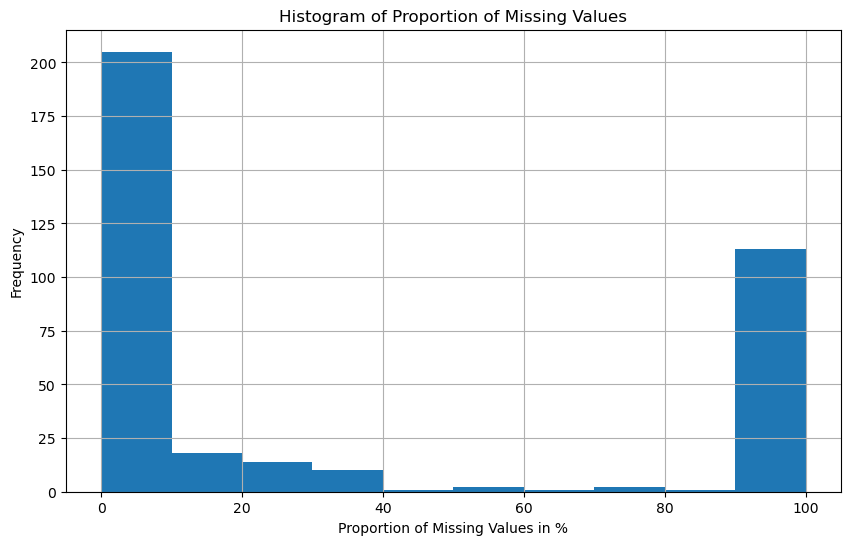

Number of columns after filtering: 202


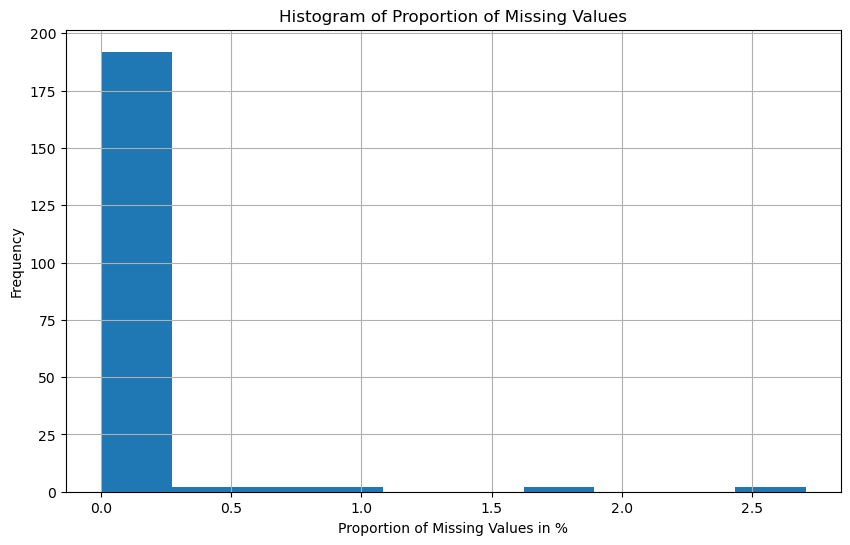

In [3]:
data = dp.data_loading(data_original)
print("="*120)
print("Number of columns before filtering:", data.shape[1])
mp.plot_missing_values(data)

data_filtered = dp.feature_filter(data)

print("="*120)
print("Number of columns after filtering:", data_filtered.shape[1])
mp.plot_missing_values(data_filtered)

## Imputation

## Baseline MOdel

In [22]:
data_imputed = dp.fillnas_and_convert(data, dataOffset="Y")
X_train, y_train, X_val, y_val, X_test, y_test = m.split_train_val_test(data_imputed)
input_dim=X_train.shape[1]

In [23]:
model_classes = [
    m.OLSModel(),
    # m.OLS3Model(),
    m.PLSModel(),
    m.LASSOModel(),
    m.ElasticNetModel(),
    # m.GBRTModel(),
    # m.RFModel(),
    m.XGBoostModel()
]

num_layers_range = range(1, 6)
for num_layers in num_layers_range:
    model_classes.append(m.NNModel(input_dim=input_dim, num_layers=num_layers))

model_r_2 = {}
models_fitted = {}
model_res = pd.DataFrame()
model_res.index = y_val.index
for model_class in model_classes:
    model_name = model_class.name if hasattr(model_class, "name") else model_class.__class__.__name__
    print(model_name)
    model_fitted, scaler = m.train(X_train, y_train, model_class)
    validation_res = m.validation(X_val, model_fitted, scaler)
    r_2 = e.calculate_r2_oos(validation_res, y_val.values)

    models_fitted[model_name] = model_fitted
    model_res[model_name] = validation_res
    model_r_2[model_name] = r_2
model_res['y'] = y_val
for model_name, r_2 in model_r_2.items():
    print(f"{model_name}: {r_2}")

OLSModel
PLSModel
LASSOModel
ElasticNetModel
XGBoostModel
NNModel_nn1


Training: 100%|██████████| 50/50 [00:01<00:00, 47.62it/s, loss=0.248]


NNModel_nn2


Training: 100%|██████████| 50/50 [00:01<00:00, 47.57it/s, loss=0.246]


NNModel_nn3


Training: 100%|██████████| 50/50 [00:01<00:00, 44.33it/s, loss=0.245]


NNModel_nn4


Training: 100%|██████████| 50/50 [00:01<00:00, 40.85it/s, loss=0.245]


NNModel_nn5


Training: 100%|██████████| 50/50 [00:01<00:00, 36.74it/s, loss=0.247]

OLSModel: -64.02858208065342
PLSModel: 3.023841908279244
LASSOModel: 0.632571254500073
ElasticNetModel: 0.632571254500073
XGBoostModel: 0.05378451202907175
NNModel_nn1: -127.43471824682246
NNModel_nn2: -98.1207043308959
NNModel_nn3: -87.04445672595074
NNModel_nn4: -80.68402841877875
NNModel_nn5: -81.0098120419339


## Hyperparameter tuning

In [ ]:
for model_class in model_classes:
    model_name = model_class.name if hasattr(model_class, "name") else model_class.__class__.__name__
    print(model_name)

OLSModel
PLSModel
LASSOModel
ElasticNetModel
XGBoostModel
NNModel_nn1
NNModel_nn2
NNModel_nn3
NNModel_nn4
NNModel_nn5


In [ ]:
models_to_tune = [
    m.OLSModel,
    m.OLS3Model,
    m.PLSModel,
    m.LASSOModel,
    m.ElasticNetModel,
    m.GBRTModel,
    m.RFModel,
    m.XGBoostModel
]
best_trials = e.hyperparameter_tuning(X_train, y_train, X_val, y_val, models_to_tune, n_trials=3)

Tuning Models:   0%|          | 0/1 [00:00<?, ?it/s][I 2024-03-18 09:51:02,015] A new study created in memory with name: no-name-20807512-0f49-4cd5-81e4-accc4d7ee244
[I 2024-03-18 09:51:02,060] Trial 0 finished with value: -30.50158702884221 and parameters: {'epsilon': 1.3197592628513748, 'alpha': 0.00016007777406174895}. Best is trial 0 with value: -30.50158702884221.
[I 2024-03-18 09:51:02,104] Trial 1 finished with value: -27.766433106071258 and parameters: {'epsilon': 1.2672730909253258, 'alpha': 0.008100839407380375}. Best is trial 1 with value: -27.766433106071258.
[I 2024-03-18 09:51:02,147] Trial 2 finished with value: -68.27606477720661 and parameters: {'epsilon': 1.9700078780797425, 'alpha': 0.0013374025898056743}. Best is trial 1 with value: -27.766433106071258.
Tuning Models: 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]

Tunning OLSModel
Best trial for OLSModel: {'epsilon': 1.2672730909253258, 'alpha': 0.008100839407380375}


## Feature Importance

In [ ]:
data_imputed = dp.fillnas_and_convert(data, dataOffset="Y")
X_train, y_train, X_val, y_val, X_test, y_test = m.split_train_val_test(data_imputed)

In [ ]:
features = X_train.columns[:10]  
importance_df, percentage_change_df = e.reduction_in_r2(model_classes, X_train, y_train, features=features, permutation_importance=False)

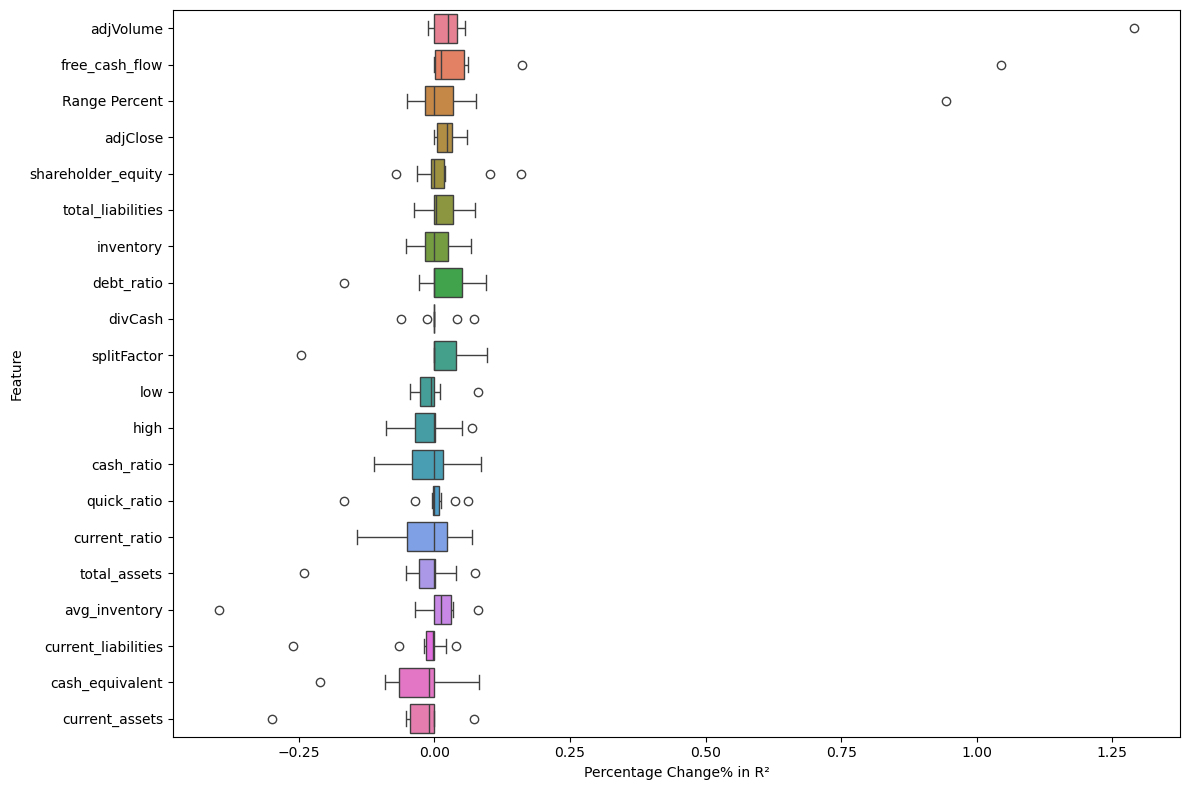

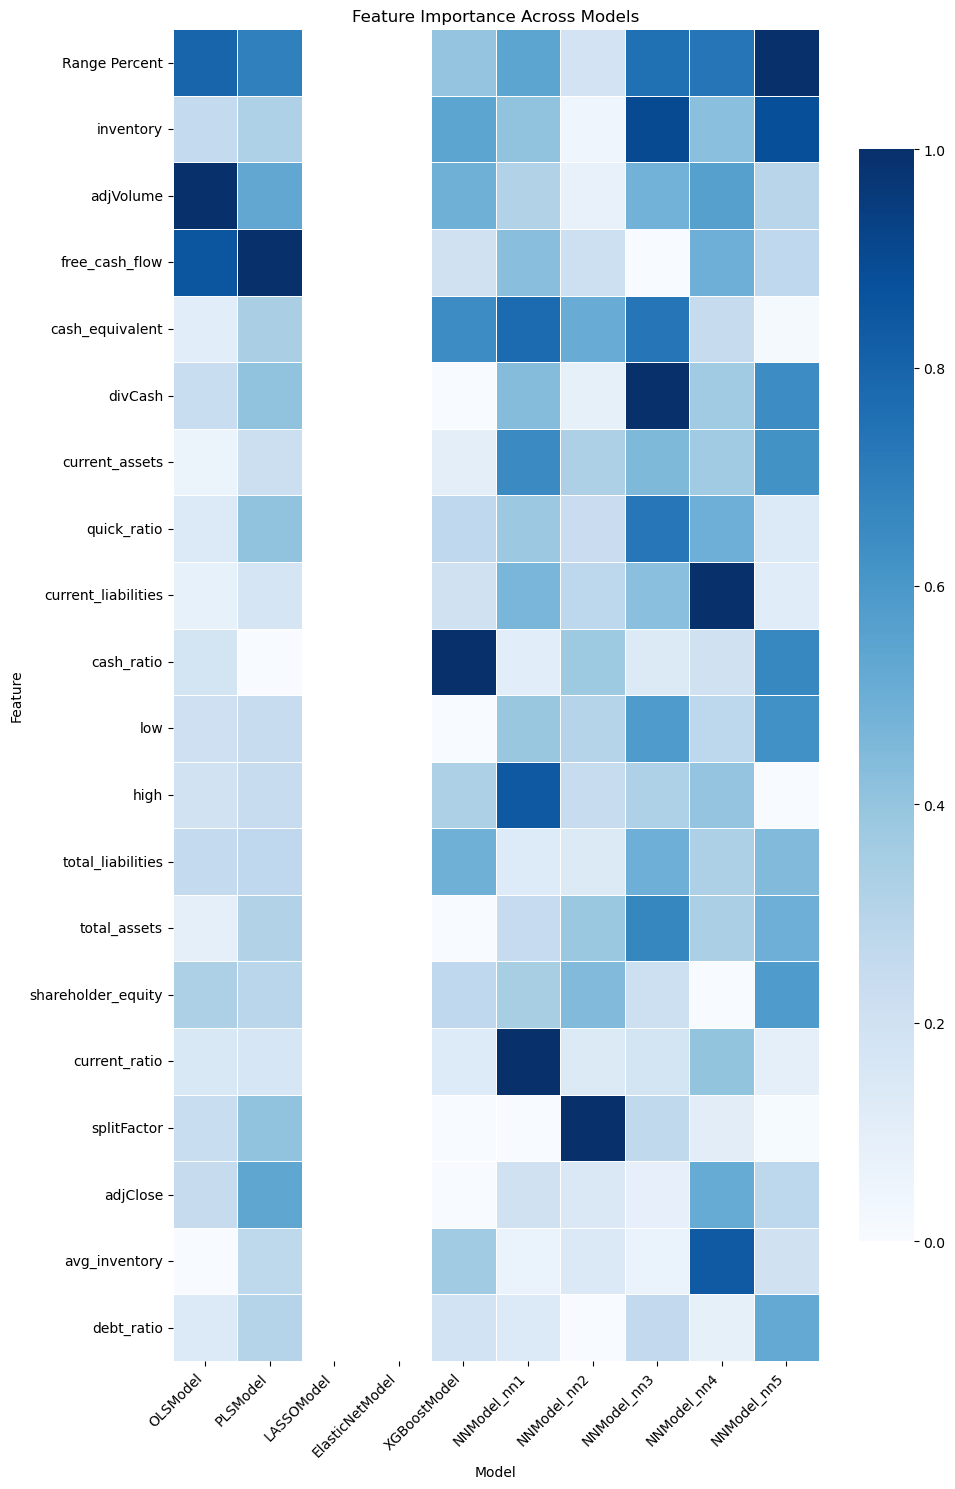

In [ ]:
mp.macroeconomic_feature_importance(percentage_change_df)
sorted_df = mp.characteristic_feature_importance(importance_df)

In [ ]:
importance_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

,OLSModel,PLSModel,LASSOModel,ElasticNetModel,XGBoostModel,NNModel_nn1,NNModel_nn2,NNModel_nn3,NNModel_nn4,NNModel_nn5
adjClose,0.249012,0.535320,NaN,NaN,0.000000,0.195556,0.147776,0.084070,0.511982,0.277620
divCash,0.235684,0.408386,NaN,NaN,0.000000,0.435323,0.087351,1.000000,0.369377,0.641659
splitFactor,0.235684,0.408386,NaN,NaN,0.000000,0.000000,1.000000,0.266834,0.106342,0.009398
adjVolume,1.000000,0.530571,NaN,NaN,0.489608,0.312795,0.076947,0.482523,0.564411,0.293193
high,0.192359,0.243752,NaN,NaN,0.330517,0.840431,0.242346,0.323686,0.399770,0.000000
low,0.210835,0.246048,NaN,NaN,0.000000,0.389888,0.304362,0.584297,0.280286,0.628155
Range Percent,0.794105,0.692826,NaN,NaN,0.400453,0.540072,0.185306,0.750014,0.732207,1.000000
current_assets,0.058728,0.219111,NaN,NaN,0.104737,0.648784,0.329381,0.450903,0.367783,0.621946
current_liabilities,0.081041,0.171633,NaN,NaN,0.199174,0.463692,0.277522,0.425212,1.000000,0.114102
current_ratio,0.151629,0.165065,NaN,NaN,0.132366,1.000000,0.134965,0.183351,0.402391,0.092743


## Portfolio analysis

,y,y_pred
date,,
2016-12-31,0.484754,0.400450
2017-12-31,-0.053913,0.443798
2018-12-31,0.889666,0.411401
2016-12-31,0.252948,0.385271
2017-12-31,-0.016473,0.324491
...,...,...
2017-12-31,0.058428,0.420909
2018-12-31,0.323613,0.369874
2016-12-31,0.140996,0.384121


In [ ]:

deciles  = e.sort_into_deciles(model_res['NNModel_nn4']['y_pred'])


In [ ]:
e.form_portfolios(model_res)

TypeError: form_portfolios() missing 1 required positional argument: 'weights'

In [ ]:
model_res

,OLSModel,PLSModel,LASSOModel,ElasticNetModel,XGBoostModel,NNModel_nn1,NNModel_nn2,NNModel_nn3,NNModel_nn4,NNModel_nn5,y
date,,,,,,,,,,,
2016-12-31,-0.487052,-0.163037,0.297893,0.297893,-0.031746,0.294952,0.410073,0.380880,0.290550,0.349766,0.484754
2017-12-31,-0.926355,-0.545098,0.297893,0.297893,0.015032,0.399675,0.534807,0.489857,0.299706,0.390968,-0.053913
2018-12-31,-0.370243,-0.389209,0.297893,0.297893,0.691071,0.325002,0.478506,0.435811,0.309113,0.372738,0.889666
2016-12-31,0.253291,-0.076439,0.297893,0.297893,0.232841,0.283897,0.418459,0.346112,0.285511,0.287391,0.252948
2017-12-31,-0.145631,-0.528104,0.297893,0.297893,0.447613,0.401003,0.381453,0.330073,0.267100,0.327111,-0.016473
...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31,-0.253842,-0.371913,0.297893,0.297893,0.107320,0.443969,0.459637,0.460191,0.317438,0.363649,0.058428
2018-12-31,-0.240861,-0.096108,0.297893,0.297893,0.118220,0.250249,0.352350,0.397294,0.296379,0.338790,0.323613
2016-12-31,0.005999,-0.066499,0.297893,0.297893,0.117247,0.374462,0.313166,0.386069,0.306329,0.312464,0.140996
